In [1]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import os
import sys
from pathlib import Path
import IPython
from scipy import signal
import scipy.fftpack
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import unittest

import schemdraw
import schemdraw.elements as elm

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

directory_path = Path(os.path.abspath('')).resolve()

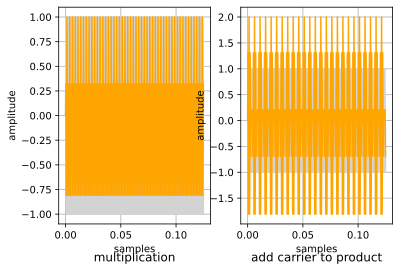

In [2]:
f1 = 1000
f2 = 200

N = 1000
# sample spacing
T = 1.0 / 8000.0
x = np.linspace(0.0, N*T, N, endpoint=False)

y1 = np.sin(f1 * 2.0 * np.pi * x)
y2 = np.sin(f2 * 2.0 * np.pi * x)
y3 = np.sin(f1 * 2.0 * np.pi * x) * np.sin(f2 * 2.0 * np.pi * x)
y4 = np.sin(f1 * 2.0 * np.pi * x) * np.sin(f2 * 2.0 * np.pi * x) + np.sin(f1 * 2.0 * np.pi * x)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=False)

#plot multiplication
ax0.plot(x, y1, c='LightGrey')  # differential output
ax0.plot(x, y2, c='LightGrey')  # differential output
ax0.plot(x, y3, c='orange')  # differential output
ax0.grid()
ax0.set_xlabel('samples')
ax0.set_ylabel('amplitude')
ax0.set_title('multiplication', y=-0.2)

#plot multiplication with carrier added
ax1.plot(x, y1, c='LightGrey')  # differential output
ax1.plot(x, y2, c='LightGrey')  # differential output
ax1.plot(x, y4, c='orange')  # differential output
ax1.grid()
ax1.set_xlabel('samples')
ax1.set_ylabel('amplitude')
ax1.set_title('add carrier to product', y=-0.2)
plt.show()

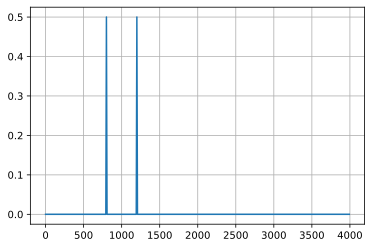

In [3]:
from scipy.fft import fft, fftfreq
y = y3
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

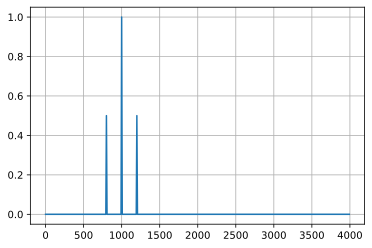

In [4]:
y = y4
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

## differential pair



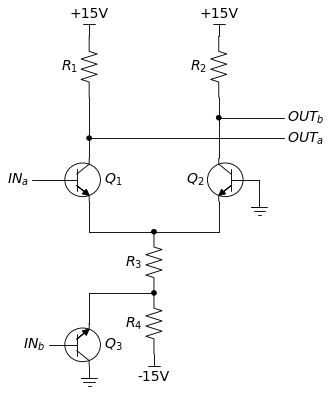

In [5]:
d = schemdraw.Drawing(unit=2.0, inches_per_unit=0.5, lw=0.9)

Q1 = d.add(elm.BjtNpn( label='$Q_1$', circle=True))
d.add(elm.Line("up"))
d.add(elm.Resistor( "up", label="$R_1$"))
d.add(elm.Vdd(label="+15V"))

d.add(elm.Line("left",  xy=Q1.base, l=d.unit/2, lftlabel="$IN_a$"))

L_Q1_emmitter = d.add(elm.Line("down",  xy=Q1.emitter, l=d.unit/2))
d.add(elm.Line("right", l=d.unit*2))
d.add(elm.Line("up", l=d.unit/2))
Q2 = d.add(elm.BjtNpn("right", lftlabel='$Q_2$', anchor="emitter", circle=True, reverse=True))
d.add(elm.Line("up", xy=Q2.collector))
d.add(elm.Resistor( "up", label="$R_2$"))
d.add(elm.Vdd(label="+15V"))

d.add(elm.Line("right", xy=Q2.base, l=d.unit/4))
d.add(elm.Line("down", l=d.unit/4))
d.add(elm.Ground())

d.add(elm.Dot(xy=[L_Q1_emmitter.end[0]+d.unit, L_Q1_emmitter.end[1]]))
R3 = d.add(elm.Resistor( "down", label="$R_3$"))
d.add(elm.Dot())
d.add(elm.Resistor( "down", label="$R_4$"))
d.add(elm.Vss(botlabel="-15V"))

d.add(elm.Line("left", l=d.unit, xy=R3.end))
d.add(elm.Line("down", l=d.unit/2))
Q3 = d.add(elm.BjtNpn("right", rgtlabel='$Q_3$', anchor="emitter", circle=True, flip=True))
d.add(elm.Ground(xy=Q3.collector))
d.add(elm.Line("left", xy=Q3.base, l=d.unit/4, lftlabel="$IN_b$"))

d.add(elm.Dot(xy=[Q1.collector[0], Q1.collector[1]+d.unit/3]))
L_OUT_A = d.add(elm.Line("right", l=d.unit*3, rgtlabel="$OUT_a$"))
d.add(elm.Dot(xy=[Q2.collector[0], Q2.collector[1]+d.unit/3*2]))
d.add(elm.Line("right", tox=L_OUT_A.end, rgtlabel="$OUT_b$"))

d.draw()

In [6]:
circuit = Circuit('differential pair')
circuit.include(spice_library['BC547B'])

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', '-15V', circuit.gnd, 'DC -15')
circuit.V('3', 'IN_a', circuit.gnd, 'DC 0V AC 0V SIN(0 25m 1k)')
circuit.V('4', 'IN_b', circuit.gnd, 'DC 0V AC 0V SIN(0 5 100)')

circuit.BJT('1', 'OUT_A', 'IN_a', 'R3_in', model="BC547B")
circuit.BJT('2', 'OUT_B', circuit.gnd, 'R3_in', model="BC547B")
circuit.BJT('3', circuit.gnd, 'IN_b', 'R3_out', model="BC547B")

circuit.R(1, 'OUT_A', '+15V', 15@u_kΩ)
circuit.R(2, 'OUT_B', '+15V', 15@u_kΩ)
circuit.R(3, 'R3_in', 'R3_out', 33@u_kΩ)
circuit.R(4, 'R3_out', '-15V', 15@u_kΩ);


In [7]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=20@u_ms)

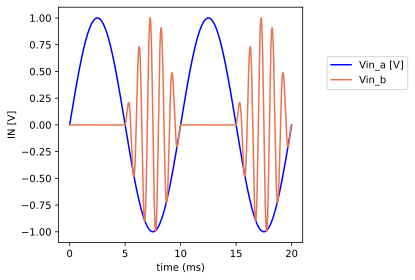

In [8]:
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time (ms)')
ax1_buffer.set_ylabel('IN [V]')
#ax1_buffer.plot(u_ms(analysis['IN_a'].abscissa), analysis['IN_a'], color='Blue')
ax1_buffer.plot(u_ms(analysis['IN_b'].abscissa), analysis['IN_b'] / 5, color='Blue')
#ax1_buffer.plot(u_ms(analysis['OUT_A'].abscissa), analysis['OUT_A'], color='Grey')
#ax1_buffer.plot(u_ms(analysis['OUT_A'].abscissa), analysis['OUT_B'], color='Grey')
ax1_buffer.plot(u_ms(analysis['OUT_A'].abscissa), analysis['OUT_B'] - analysis['OUT_A'], color='#E97451')
ax1_buffer.legend(('Vin_a [V]', 'Vin_b', 'Vout [V]'), loc=(1.1,0.65))

plt.tight_layout()
plt.show()

## gilbert cell



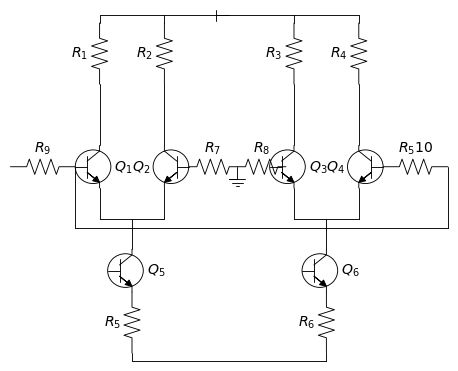

In [9]:
d = schemdraw.Drawing(unit=2.0, inches_per_unit=0.5, lw=0.9)

Q1 = d.add(elm.BjtNpn( label='$Q_1$', circle=True))
R9 = d.add(elm.Resistor( "left", label="$R_9$", xy=Q1.base))

d.add(elm.Line("up", xy=Q1.collector, l=d.unit))
d.add(elm.Resistor("up", label="$R_1$"))
d.add(elm.Line("up", l=d.unit/8))
d.add(elm.Line("right", l=d.unit))

d.add(elm.Line("down", xy=Q1.emitter, l=d.unit/2))
L1 = d.add(elm.Line("right", l=d.unit/2))
d.add(elm.Line("right", l=d.unit/2))
d.add(elm.Line("up", l=d.unit/2))
Q2 = d.add(elm.BjtNpn( "right", lftlabel='$Q_2$', circle=True, anchor='emitter', reverse=True))
d.add(elm.Line("up", l=d.unit, xy=Q2.collector))
d.add(elm.Resistor("up", label="$R_2$"))
d.add(elm.Line("up", l=d.unit/8))
L2 = d.add(elm.Line("right", l=d.unit))
d.add(elm.Vdd("up"))

L3 = d.add(elm.Line("right", xy=L2.end, l=d.unit))
d.add(elm.Line("down", l=d.unit/8))
d.add(elm.Resistor("down", label="$R_3$"))
d.add(elm.Line("down", l=d.unit))
Q3 = d.add(elm.BjtNpn( "right", label='$Q_3$', circle=True, anchor='collector'))

R7 = d.add(elm.Resistor("right", label="$R_7$", xy=Q2.base, l=d.unit*0.75))
d.add(elm.Resistor("right", label="$R_8$", l=d.unit*0.75))
d.add(elm.Ground(xy=R7.end))

d.add(elm.Line("down", xy=Q3.emitter, l=d.unit/2))
L5 = d.add(elm.Line("right", l=d.unit/2))
d.add(elm.Line("right", l=d.unit/2))
d.add(elm.Line("up", l=d.unit/2))

L4 = d.add(elm.Line("right", xy=L3.end, l=d.unit))
d.add(elm.Line("down", l=d.unit/8))
d.add(elm.Resistor("down", label="$R_4$"))
d.add(elm.Line("down", l=d.unit))
Q4 = d.add(elm.BjtNpn( "right", lftlabel='$Q_4$', circle=True, anchor='collector', reverse=True))

d.add(elm.Resistor("right", label="$R_510$", xy=Q4.base))
d.add(elm.Line("down", l=d.unit))
d.add(elm.Line("left", tox=R9.start))
d.add(elm.Line("up", l=d.unit))

d.add(elm.Line("down", xy=L1.end, l=d.unit/2))
Q5 = d.add(elm.BjtNpn( "right", label='$Q_5$', circle=True, anchor='collector'))
d.add(elm.Resistor("down", label="$R_5$", xy=Q5.emitter))
d.add(elm.Line("down", l=d.unit/8))
d.add(elm.Line("right", l=d.unit*1.5))
d.add(elm.Line("right", l=d.unit*1.5))
d.add(elm.Line("up", l=d.unit/8))
d.add(elm.Resistor("up", label="$R_6$"))


d.add(elm.Line("down", xy=L5.end, l=d.unit/2))
Q6 = d.add(elm.BjtNpn( "right", label='$Q_6$', circle=True, anchor='collector'))

#Q2 = d.add(elm.BjtNpn( label='$Q_2$', circle=True))
#Q3 = d.add(elm.BjtNpn( label='$Q_3$', circle=True))
#Q4 = d.add(elm.BjtNpn( label='$Q_4$', circle=True))


#R1 = d.add(elm.Resistor( "left", label='$R_1$'))
##d.add(logic.Dot())    
#R2 = d.add(elm.Resistor( "down", label='$R_3$'))
#d.add(elm.Resistor( "down", label='$R_4$'))
#d.add(elm.Ground)

d.draw()